In [171]:
%matplotlib notebook

import sys
import os
import numpy as np
import cv2
sys.path.append("./utils/") # Adds higher directory to python modules path.
import loadcoraldata_utils as coralutils
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from NeMO_losses import charbonnierLoss
import NeMO_layers
from keras.models import Model, Sequential, load_model
from scipy.misc import imresize
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from metrics import metrics
import json

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

%matplotlib notebook

# model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
model = load_model('./tmp/SharpMask_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
# SRmodel = load_model('./tmp/SR_FeatureWise_Oct7.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 
#                                                     'charbonnierLoss': charbonnierLoss})
# SRmodel = load_model('./tmp/SRx2_Fiji_4channel_2dTranpose_ConvUpsample.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 
#                                                     'charbonnierLoss': charbonnierLoss})
SRmodel = load_model('./tmp/SR_FeatureWise2.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 
                                                    'charbonnierLoss': charbonnierLoss})


(4271, 8965, 4)
2019-10-13T21:51:35.887451Z


<IPython.core.display.Javascript object>


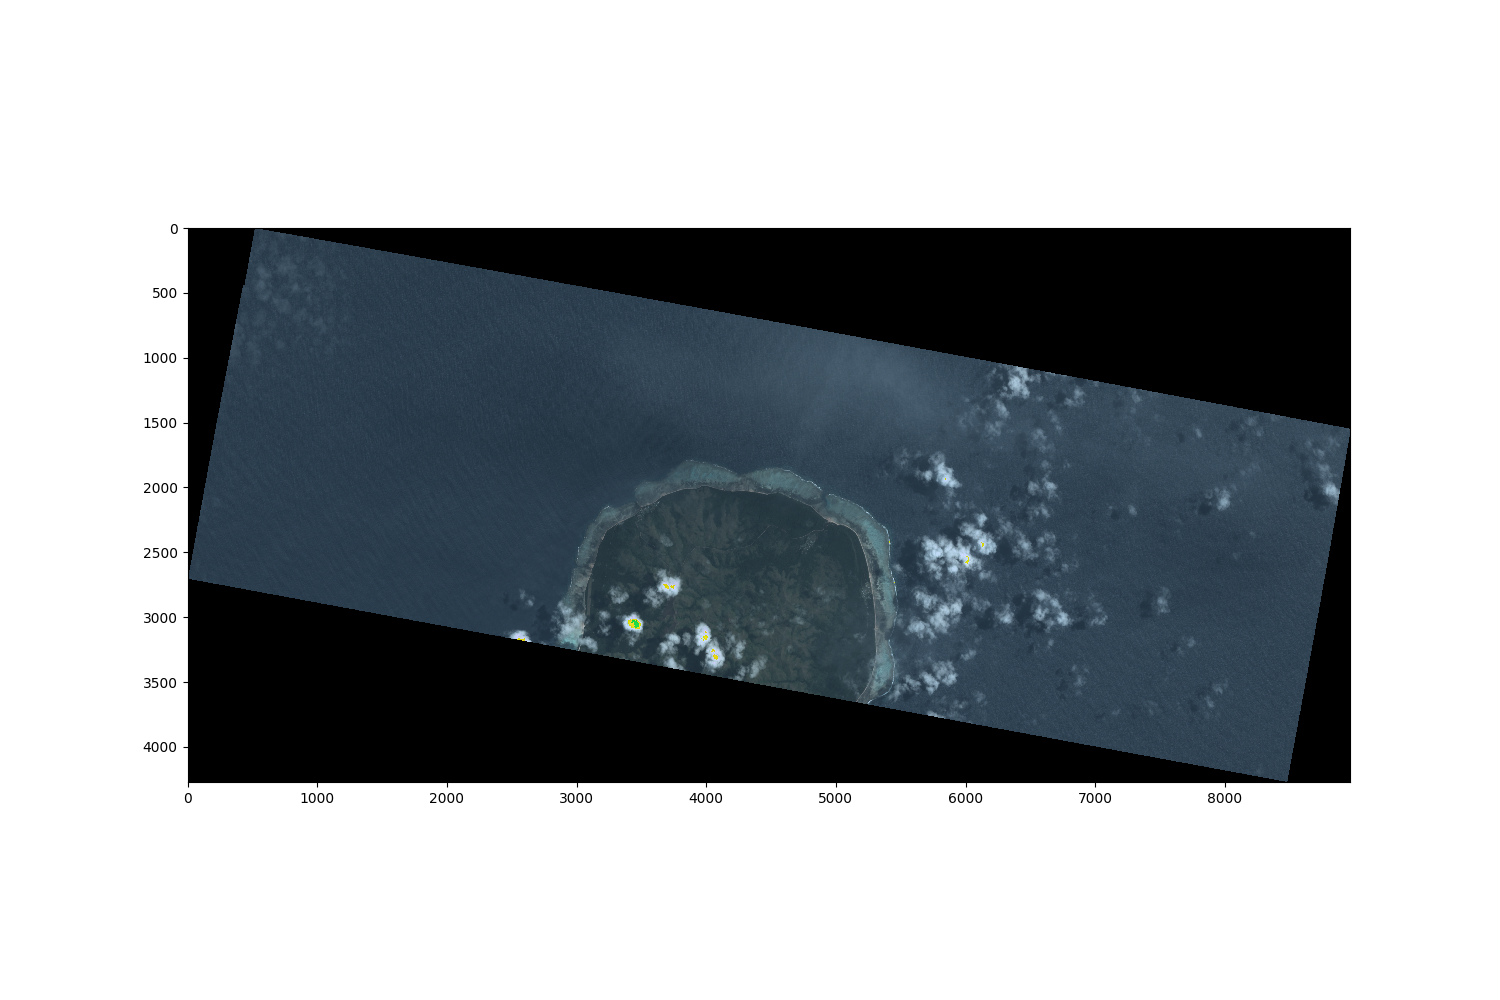

maximums: [336.6135  238.20647 291.35535 190.85025]
[77.14059  61.68966  43.992374 21.619886]


In [249]:
import math

infopath = '/home/asli/NeMO-Test/NeMO-NET/Images/ForJarrett_SpecificTrainTruth_512/CoralInfo.txt'
imgnum = 18
# GoodPlanetData = ['09', '10', '11', '14', '15', '18', '19']

with open(infopath) as fp:
    line = fp.readline()
    cnt = 1
    while cnt <= imgnum: 
        line = fp.readline()
        cnt += 1
linesplit = line.split()
xstart = int(linesplit[-1])
ystart = int(linesplit[-2])
imgpath = " ".join(linesplit[:-2])
jsonpath = imgpath[:imgpath.find('3B_AnalyticMS.tif')] + 'metadata.json'
xmlpath = imgpath[:imgpath.find('3B_AnalyticMS.tif')] + '3B_AnalyticMS_metadata.xml'

img = coralutils.CoralData(imgpath, load_type="raster")
# jsonpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_336801/20181216_214344_0f35/20181216_214344_0f35_metadata.json"
# xmlpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_336801/20181216_214344_0f35/20181216_214344_0f35_3B_AnalyticMS_metadata.xml"

# img = coralutils.CoralData("/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190201_214454_101e/20190201_214454_101e_3B_AnalyticMS.tif", load_type="raster")
# jsonpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190201_214454_101e/20190201_214454_101e_metadata.json"
# xmlpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190201_214454_101e/20190201_214454_101e_3B_AnalyticMS_metadata.xml"

# img = coralutils.CoralData("/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190307_220637_1053/20190307_220637_1053_3B_AnalyticMS.tif", load_type="raster")
# jsonpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190307_220637_1053/20190307_220637_1053_metadata.json"
# xmlpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190307_220637_1053/20190307_220637_1053_3B_AnalyticMS_metadata.xml"

# There's some clouds over area here
# img = coralutils.CoralData("/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190512_215344_1020/20190512_215344_1020_3B_AnalyticMS.tif", load_type="raster") 
# jsonpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190512_215344_1020/20190512_215344_1020_metadata.json"
# xmlpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190512_215344_1020/20190512_215344_1020_3B_AnalyticMS_metadata.xml"

# Secondary area
# img = coralutils.CoralData("/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190307_220638_1053/20190307_220638_1053_3B_AnalyticMS.tif", load_type="raster")
# jsonpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190307_220638_1053/20190307_220638_1053_metadata.json"
# xmlpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190307_220638_1053/20190307_220638_1053_3B_AnalyticMS_metadata.xml"

# img = coralutils.CoralData("/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190512_215344_1020/20190512_215344_1020_3B_AnalyticMS.tif", load_type="raster") 
# jsonpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190512_215344_1020/20190512_215344_1020_metadata.json"
# xmlpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20190512_215344_1020/20190512_215344_1020_3B_AnalyticMS_metadata.xml"

# img = coralutils.CoralData("/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20191013_215135_1012/20191013_215135_1012_3B_AnalyticMS.tif", load_type="raster") 
# jsonpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20191013_215135_1012/20191013_215135_1012_metadata.json"
# xmlpath = "/home/shared/NeMO-Net Data/Planet/Cicia/planet_order_411635/20191013_215135_1012/20191013_215135_1012_3B_AnalyticMS_metadata.xml"

with open(jsonpath) as json_file:
    json_data = json.load(json_file)
    
print(img.image.shape)
img.truthimage = np.zeros(img.image.shape)

## calculate sun-earth distance
##------------------------------
## this function accepts acquisition time and calculates sun-earth distance
## this is used in the correction of toa radiance for solar geometry
## input: AcqTime: earliestAcqTime str from WV2 .IMD file format: YYYY_MM_DDThh:mm:ss:ddddddZ;
## output: d_ES in astromnomical units
##--------------------------------------------------------------------------------------------

def calc_d_ES( AcqTime ):
    
    AcqTime = AcqTime.strip()
    print(AcqTime)
    year    = int(AcqTime[0:4])
    month_  = AcqTime[5:7]
    month   = int(month_.lstrip("0"))
    day_    = AcqTime[8:10]
    day     = int(day_.lstrip("0"))
    hh_     = AcqTime[11:13]
    hh      = float(hh_.lstrip("0"))
    mm_     = AcqTime[14:16]
    mm      = float(mm_.lstrip("0"))
    ss_     = AcqTime[17:19]
    ss      = float(ss_.lstrip("0"))
    ms    = float(AcqTime[20:-1])
    sec   = ss + ms/(1e6)
    
    UT   = hh + mm/60. + sec/3600.
    #print("UT: ",UT)
    
    if (month == 1 or month == 2):
        year = year - 1
        month= month + 12
        
    # calculate Juliad Day (Meeus, p.61, 1998)
    A = int(year/100)
    B = 2 - A + int(A/4)
    JD= int(365.25*(year+4716)) + int(30.6001*(month + 1)) + day + UT/24. + B - 1524.5
    #print("Julian Day: ", JD)
    # calculate Earth-Sun distance (U.S. Naval Observatory)
    D  = JD - 2451545.0
    g  = 357.529 + 0.98560028*D
    gi = math.cos(math.radians(g))
    gi2= math.cos(math.radians(2*g))
    
    d_ES = 1.00014 - 0.01671*gi - 0.00014*gi2
    #print(d_ES)
    
    return (d_ES)**2

def fixRGBimg(img,pixel_mean,pixel_std,minval,maxval,dtype=np.uint8):
    fixed_img = np.copy(img)
    if type(pixel_std) == list:
        for i,std in enumerate(pixel_std):
            fixed_img[:,:,i] = fixed_img[:,:,i]*std+pixel_mean
    else:
        fixed_img = fixed_img*pixel_std+pixel_mean
    fixed_img[fixed_img > maxval] = maxval
    fixed_img[fixed_img < minval] = minval
    fixed_img = np.asarray(fixed_img, dtype=dtype)
    return fixed_img

TOA_radiance_img = fixRGBimg(img.image,0,0.01,0,10000,np.float32) # turn into 0-255
AcqTimeAll = json_data["properties"]['acquired']
d_ES_sq = calc_d_ES(AcqTimeAll)
meanSZA = 90.-json_data["properties"]["sun_elevation"]
mu = math.cos(math.radians(meanSZA))
GEO_radiance_img = (TOA_radiance_img*d_ES_sq)/mu

fig = plt.figure(1, figsize=(15,10))
pic = np.rollaxis(np.asarray([GEO_radiance_img[:,:,2], GEO_radiance_img[:,:,1], GEO_radiance_img[:,:,0]]),0,3)
pic = np.asarray(pic, dtype=np.uint8)
plt.imshow(pic)
plt.show()

print("maximums:", np.max(np.reshape(GEO_radiance_img,(img.image.shape[0]*img.image.shape[1],img.image.shape[2])),0))
print(GEO_radiance_img[1320,1293,:])

In [3]:
# Extra step for SR Featurewise model

# Input = SRmodel.get_layer("model_1").get_input_at(0)
# SR_layer = SRmodel.get_layer("model_1").get_output_at(0)

# print("Cut Model:")
# supermodel = Model(Input, SR_layer)
# supermodel.summary()

# single model
# supermodel = SRmodel
# supermodel.summary()


<IPython.core.display.Javascript object>


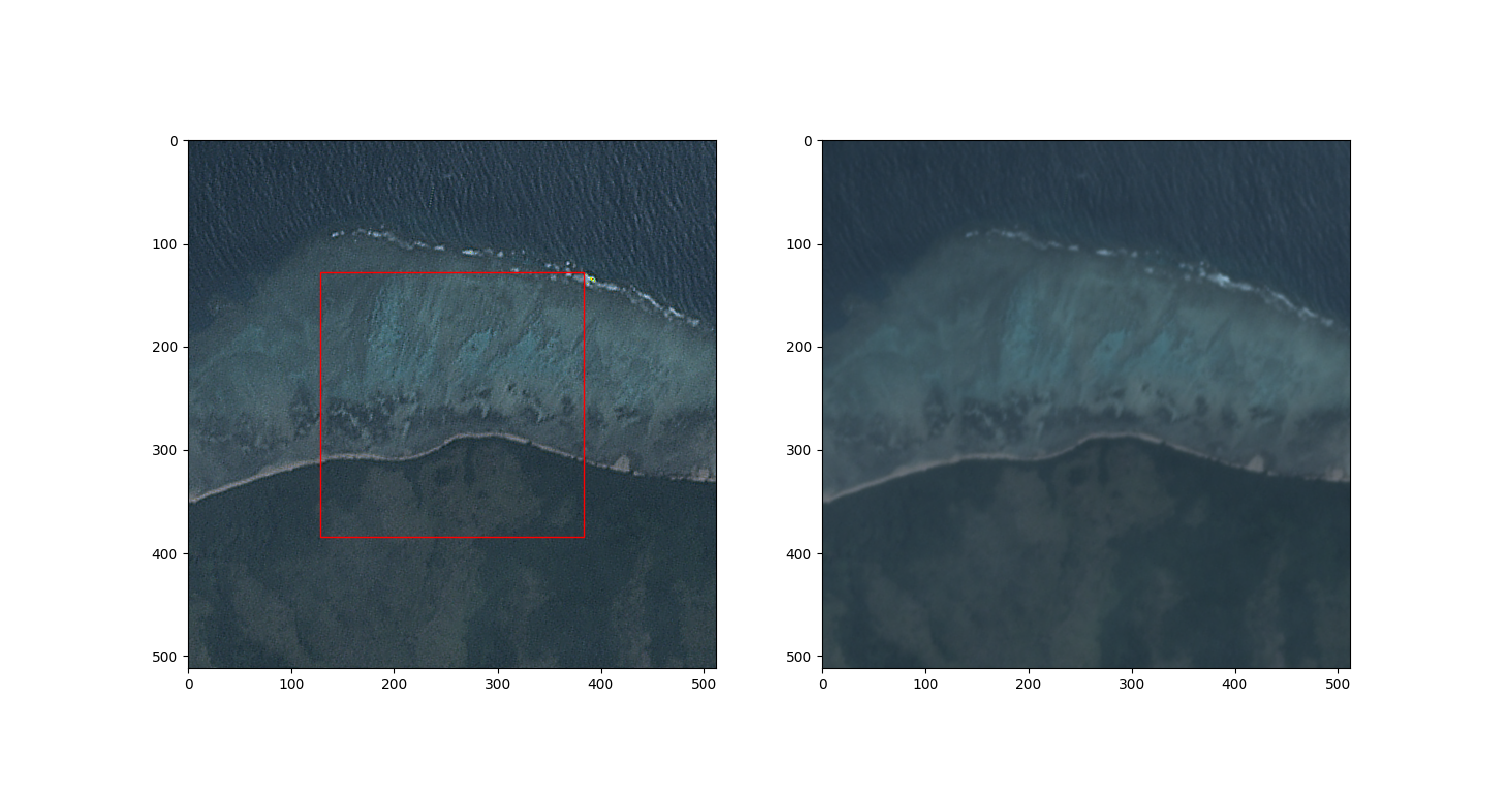

In [250]:
from keras.preprocessing.image import img_to_array, load_img
import keras.backend as K

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

# Southwest
# xgeo = 251600.0
# ygeo = 8033931.0

# North
# xgeo = 253479.0
# ygeo = 8040132.0 

# Northeast
# ygeo = 8039001.0
# xgeo = 257200.0

# xstart = 6000
# ystart = 2700
# xstart = int((xgeo-img.geotransform[0])/img.geotransform[1])
# ystart = int((ygeo-img.geotransform[3])/img.geotransform[5])

# ystart = 1523
# xstart = 5384
xlen = 512
ylen = 512

imgshape = img.image.shape
if xstart+xlen > imgshape[1] or xstart < 0 or ystart+ylen > imgshape[0] or ystart < 0:
    print("Image out of bounds!")
else:
    predict_size = 128
    crop_len = int(np.floor(256/2))
    offstart = crop_len-int(np.floor(predict_size/2))
    
    img.testimage = np.copy(GEO_radiance_img[ystart:ystart+ylen,xstart:xstart+xlen,:])
    kernel_sharpening = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    for i in range(4):
        img.testimage[:,:,i] = cv2.filter2D(img.testimage[:,:,i], -1, kernel_sharpening)

    rect = mpatches.Rectangle((128,128),256,256,linewidth=1,edgecolor='r',facecolor='none')
    fig = plt.figure(2, figsize=(15,8))
    ax = plt.subplot(121)
    pic = np.rollaxis(np.asarray([img.testimage[:,:,2], img.testimage[:,:,1], img.testimage[:,:,0]]),0,3)
    pic = np.asarray(pic, dtype=np.uint8)
    ax.imshow(pic)
    ax.add_patch(rect)

    ax = plt.subplot(122)
    ax.imshow(np.asarray(GEO_radiance_img[ystart:ystart+ylen,xstart:xstart+xlen,2::-1],dtype=np.uint8))
    plt.show()

    pixel_mean = 100
    pixel_std = 100
    samplepatch = img.testimage #BGR+NIR
    samplepatch = img_to_array(samplepatch, data_format=K.image_data_format())
    samplepatch = (samplepatch-pixel_mean)/pixel_std

# imgbatch = np.expand_dims(samplepatch, axis=0)
# imgpredict = supermodel.predict(imgbatch, batch_size = 1)[0]
# kernel_sharpening = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# imgpredict_sharpen = np.zeros(imgpredict.shape)
# for i in range(4):
#     imgpredict_sharpen[:,:,i] = cv2.filter2D(imgpredict[:,:,i], -1, kernel_sharpening)
# imgpredict_sharpen = imgpredict_sharpen*100+100

# ax = plt.subplot(122)
# ax.imshow(fixRGBimg(imgpredict_sharpen[:,:,2::-1],0,1,0,255))
# plt.show()


{1: 'Coral', 2: 'Sediment', 3: 'Beach', 4: 'Seagrass', 5: 'Terrestrial vegetation', 6: 'Deep water', 7: 'Clouds', 8: 'Wave breaking', 9: 'Other or Unknown'}
Line: 0 completed
Line: 128 completed
Line: 256 completed


<IPython.core.display.Javascript object>


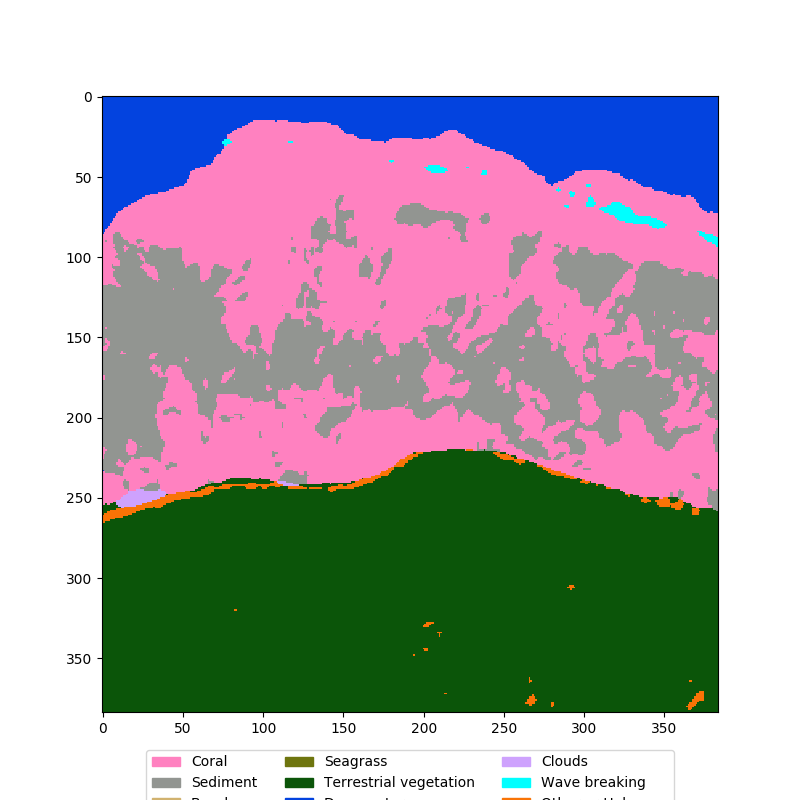

In [257]:
jsonclasspath = './utils/CoralClasses.json'

with open(jsonclasspath) as json_file:
    json_classes = json.load(json_file)

labelkey = json_classes["VedConsolidated_ClassDict"]
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev)

img.set_mean_std(100,75)
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    img.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (128,128), predict_size = predict_size, num_lines=None, lastchannelremove=False)

fig = plt.figure(3,figsize=(8,8))
plt.imshow(whole_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
plt.show()



KL-divergence at 0: -1016146.625010071
KL-divergence at 1: -1271520.6245835067
KL-divergence at 2: -1298455.4205739326
KL-divergence at 3: -1305364.1074257581
KL-divergence at 4: -1308121.4087729028
KL-divergence at 5: -1309726.7984502353
KL-divergence at 6: -1310870.9879492333
KL-divergence at 7: -1311824.1165620512
KL-divergence at 8: -1312603.510058014
KL-divergence at 9: -1313148.4771956936
KL-divergence at 10: -1313548.389737346
KL-divergence at 11: -1313871.4839293724
KL-divergence at 12: -1314147.9154600373
KL-divergence at 13: -1314356.1434752168
KL-divergence at 14: -1314511.9651178801
KL-divergence at 15: -1314656.0729966105
KL-divergence at 16: -1314784.1546571688
KL-divergence at 17: -1314899.6707677585
KL-divergence at 18: -1315010.6007014595
KL-divergence at 19: -1315093.3576519233


<IPython.core.display.Javascript object>


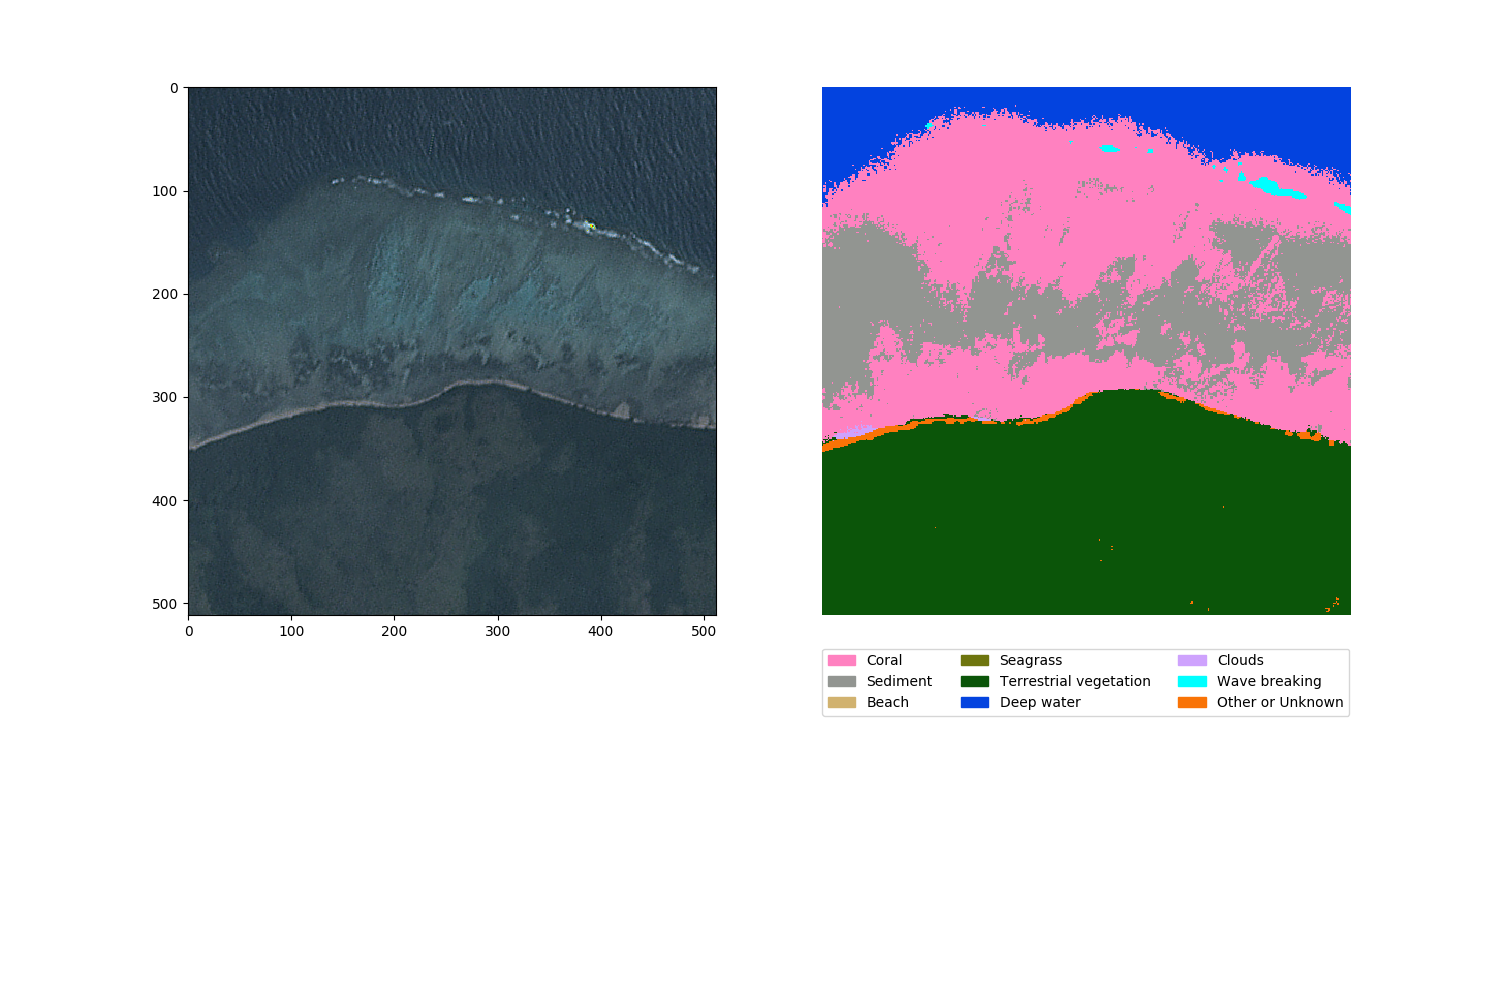

In [258]:
# Conditional random field code
import pydensecrf.densecrf as dcrf
from cv2 import imread, imwrite
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

prob_predict_switch = np.rollaxis(prob_predict,2,0)
U = unary_from_softmax(prob_predict_switch)
d = dcrf.DenseCRF2D(xlen-2*offstart, ylen-2*offstart,len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(5,5), shape=whole_predict.shape[:2]) # smaller the sdims, the more important it is
d.addPairwiseEnergy(pairwise_gaussian, compat=0, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
pairwise_bilateral = create_pairwise_bilateral(sdims=(10,10), schan=3, img=img.testimage[offstart:ylen-offstart,offstart:xlen-offstart], chdim=2) 
d.addPairwiseEnergy(pairwise_bilateral, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

MAP = np.argmax(Q, axis=0)
final_predict = np.reshape(MAP, (ylen-2*offstart, xlen-2*offstart))
# accuracy = 100*np.asarray((final_predict == Testtruth_consolidated)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
# print(accuracy)

fig = plt.figure(4,figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(pic)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])

ax = plt.subplot(122)
ax.imshow(final_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
ax.set_axis_off()
plt.show()

{'Coral': 1, 'Sediment': 2, 'Beach': 3, 'Seagrass': 4, 'Terrestrial vegetation': 5, 'Deep water': 6, 'Clouds': 7, 'Wave breaking': 8, 'Other or Unknown': 9}
# of high prob sediment:  9788
# of high prob corals:  7607
# of high prob seagrass:  0
# of high prob clouds:  0
# of high prob ocean:  0


<IPython.core.display.Javascript object>


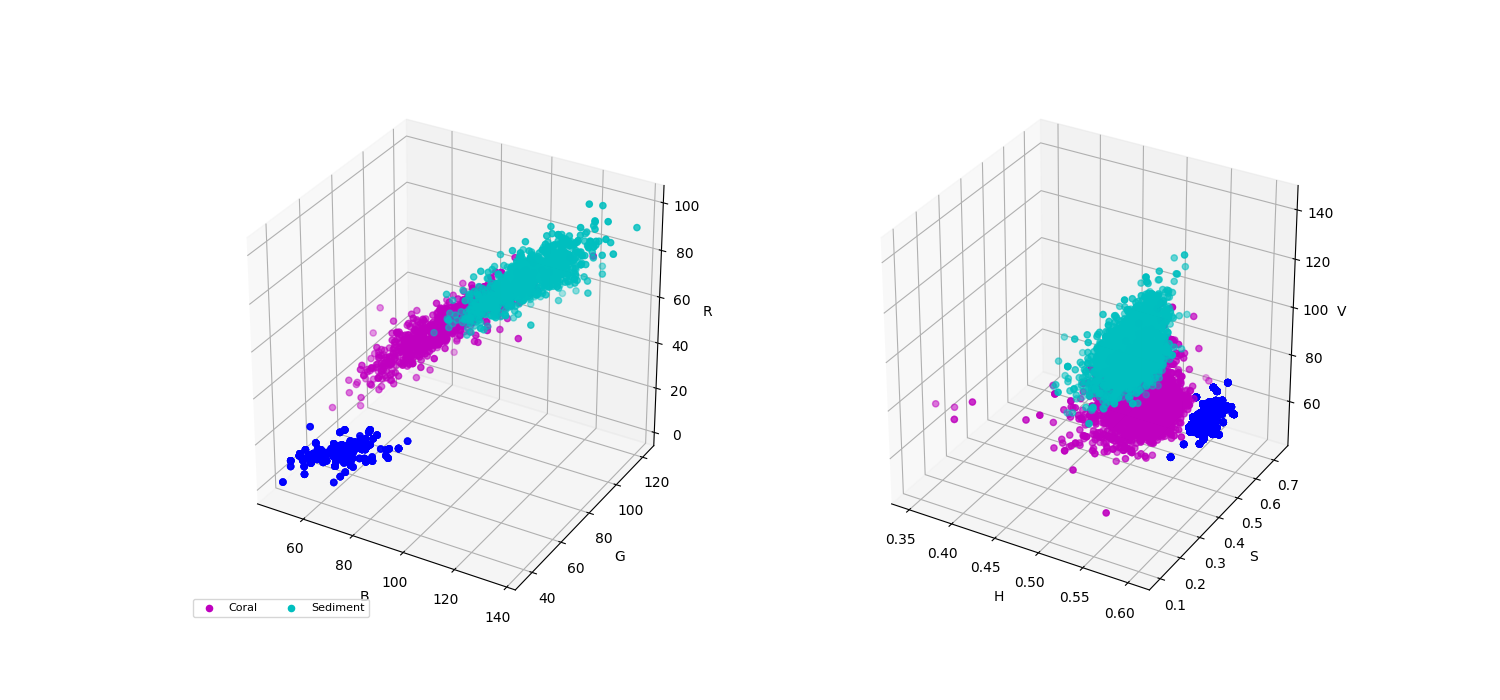

<IPython.core.display.Javascript object>


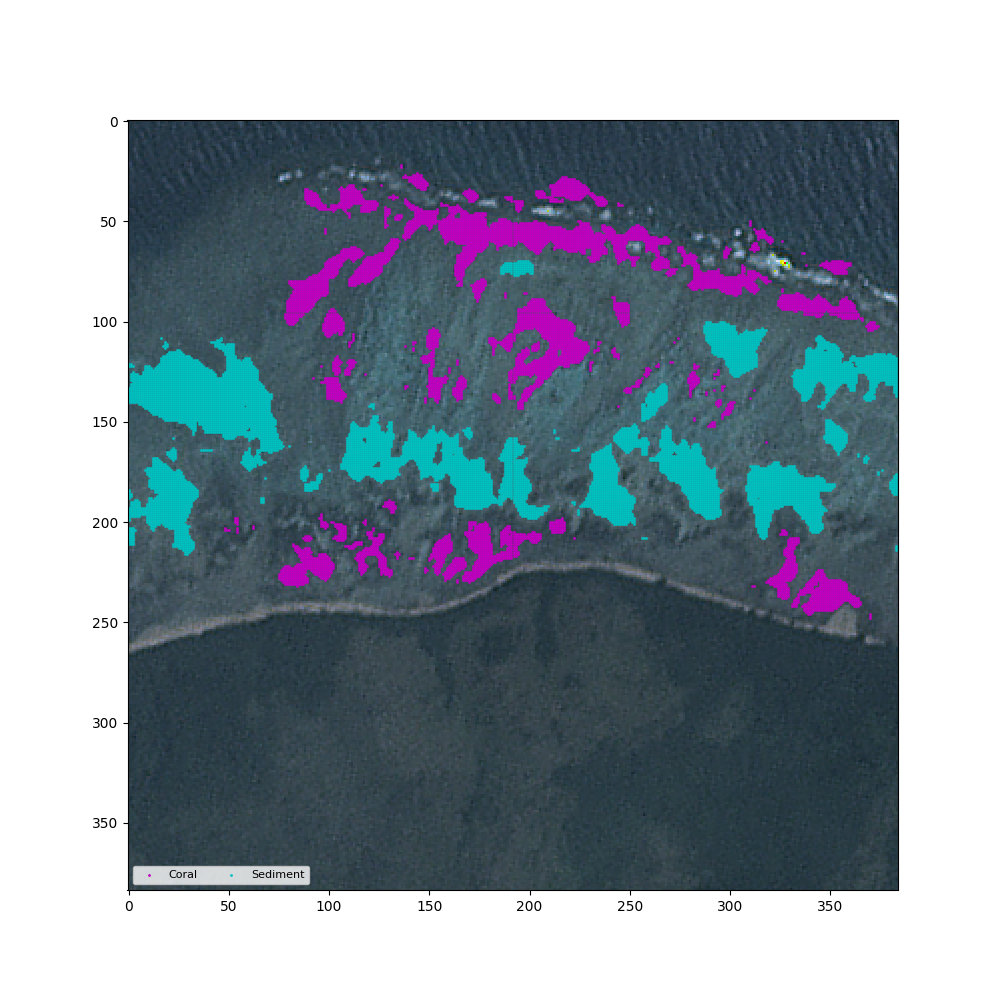

Coral statistics:  [88.295006 79.36891  59.032955 23.651897] [9.742747 9.044854 8.271165 4.880329]
Sediment statistics:  [107.001625  98.50634   73.01151   22.857315] [8.680113  7.5013375 7.6186013 3.7030327]


In [259]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from skimage.color import rgb2hsv
from sklearn.cluster import KMeans, DBSCAN
from sklearn import svm
from sklearn import neighbors

# There is still confusion between coral and sediment to a degree... we can fine tune it
print(labelkey)
n=3000
n_sg_cutoff = 100
img_HSV = rgb2hsv(img.testimage[offstart:ylen-offstart,offstart:xlen-offstart,2::-1])

sediment = np.where(final_predict.astype(int)+1 == labelkey['Sediment'])
sediment_highprob = np.where(prob_predict[:,:,1] >= 0.85)
print("# of high prob sediment: ", len(sediment_highprob[0]))
randomsed = np.random.randint(len(sediment_highprob[0]), size=n)
randomsed_hsv = img_HSV[sediment_highprob[0][randomsed],sediment_highprob[1][randomsed],:]
randomsed = img.testimage[offstart+sediment_highprob[0][randomsed],offstart+sediment_highprob[1][randomsed],:]

coralprob_cutoff = 0.9
corals = np.where(final_predict.astype(int)+1 == labelkey['Coral'])
corals_highprob = np.where(prob_predict[:,:,0] >= coralprob_cutoff)
while len(corals_highprob[0]) >= 0.75*len(sediment_highprob[0]) and coralprob_cutoff <= 0.95:
    coralprob_cutoff = coralprob_cutoff + 0.01
    corals_highprob = np.where(prob_predict[:,:,0] >= coralprob_cutoff)
while len(corals_highprob[0]) <= 0.7*len(sediment_highprob[0]) and coralprob_cutoff >= 0.5:
    coralprob_cutoff = coralprob_cutoff - 0.01
    corals_highprob = np.where(prob_predict[:,:,0] >= coralprob_cutoff)
print("# of high prob corals: ", len(corals_highprob[0]))
randomcorals = np.random.randint(len(corals_highprob[0]), size=n)
randomcorals_hsv = img_HSV[corals_highprob[0][randomcorals],corals_highprob[1][randomcorals],:]
randomcorals = img.testimage[offstart+corals_highprob[0][randomcorals],offstart+corals_highprob[1][randomcorals],:]

seagrass = np.where(final_predict.astype(int)+1 == labelkey['Seagrass'])

seagrass_highprob = np.where(prob_predict[:,:,3] >= 0.5)
print("# of high prob seagrass: ", len(seagrass_highprob[0]))
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    randomsg = np.random.randint(len(seagrass_highprob[0]), size=n)
    randomsg_hsv = img_HSV[seagrass_highprob[0][randomsg],seagrass_highprob[1][randomsg],:]
    randomsg = img.testimage[offstart+seagrass_highprob[0][randomsg],offstart+seagrass_highprob[1][randomsg],:]

clouds = np.where(final_predict.astype(int)+1 == labelkey['Clouds'])
# clouds = np.where(np.logical_and(np.equal(final_predict.astype(int)+1,labelkey["Clouds"]), np.not_equal(cloud_predict.astype(int),1))) # Predicted as clouds in nemo-model, but not predicted as clouds using cloud model
clouds_highprob = np.where(prob_predict[:,:,6] >= 0.85)
print("# of high prob clouds: ", len(clouds_highprob[0]))
if len(clouds_highprob[0]) >= 100:
    randomclouds = np.random.randint(len(clouds_highprob[0]), size=n)
    randomclouds = img.testimage[offstart+clouds_highprob[0][randomclouds], offstart+clouds_highprob[1][randomclouds],:]
    
ocean = np.where(final_predict.astype(int)+1 == labelkey['Deep water'])
ocean_highprob = np.where(prob_predict[:,:,5] >= 0.99)
print("# of high prob ocean: ", len(ocean_highprob[0]))
if len(ocean_highprob[0]) >= 100:
    randomocean = np.random.randint(len(ocean_highprob[0]), size=n)
    randomocean_hsv = img_HSV[ocean_highprob[0][randomocean], ocean_highprob[1][randomocean],:]
    randomocean = img.testimage[offstart+ocean_highprob[0][randomocean], offstart+ocean_highprob[1][randomocean],:]
    
# plot 3d scatterplot
nscatter = 1000
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121, projection='3d')
coral_scatter = ax.scatter(randomcorals[:nscatter,0], randomcorals[:nscatter,1], randomcorals[:nscatter,2], c='m',marker='o')
sediment_scatter = ax.scatter(randomsed[:nscatter,0], randomsed[:nscatter,1], randomsed[:nscatter,2], c='c',marker='o')
ocean_scatter = ax.scatter(randomocean[:nscatter,0], randomocean[:nscatter,1], randomocean[:nscatter,3], c='b', marker='o')
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    seagrass_scatter = ax.scatter(randomsg[:nscatter,0], randomsg[:nscatter,1], randomsg[:nscatter,2], c='g',marker='o')
    plt.legend((coral_scatter, sediment_scatter, seagrass_scatter), ('Coral', 'Sediment', 'Seagrass'),scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
else:
    plt.legend((coral_scatter, sediment_scatter), ('Coral', 'Sediment'),scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
# if len(clouds_highprob[0]) >= 100:
#     ax.scatter(randomclouds[:,0], randomclouds[:,1], randomclouds[:,2], c='k', marker='o')
ax.set_xlabel('B')
ax.set_ylabel('G')
ax.set_zlabel('R')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(randomcorals_hsv[:,0], randomcorals_hsv[:,1], randomcorals_hsv[:,2], c='m',marker='o')
ax.scatter(randomsed_hsv[:,0], randomsed_hsv[:,1], randomsed_hsv[:,2], c='c',marker='o')
ax.scatter(randomocean_hsv[:,0], randomocean_hsv[:,1], randomocean_hsv[:,2], c='b', marker='o')
if len(seagrass_highprob[0]) >= 100:
    ax.scatter(randomsg_hsv[:,0], randomsg_hsv[:,1], randomsg_hsv[:,2], c='g',marker='o')
ax.set_xlabel('H')
ax.set_ylabel('S')
ax.set_zlabel('V')
plt.show()

# KNN classification algorithm between coral, sediment, (seagrass), ocean
combineALL = np.concatenate((randomcorals[:,:], randomsed[:,:]), axis=0)
y = np.concatenate((np.zeros(n,), np.ones(n,)), axis=0)
numcombine = 2
combineidx = {"Coral":0, "Sediment":1}
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    combineALL = np.concatenate((combineALL[:,:],randomsg[:,:]), axis=0)
    y = np.concatenate((y, numcombine*np.ones(n,)), axis=0)
    combineidx["Seagrass"] = numcombine
    numcombine = numcombine+1
if len(ocean_highprob[0]) >= 100:
    combineALL = np.concatenate((combineALL[:,:],randomocean[:,:]), axis=0)
    y = np.concatenate((y, numcombine*np.ones(n,)), axis=0)
    combineidx["Ocean"] = numcombine
    numcombine = numcombine+1
clf_all = neighbors.KNeighborsClassifier(10,weights='distance')
clf_all.fit(combineALL,y)

if len(clouds_highprob[0]) >= 100:
    clustering = DBSCAN(eps=5, min_samples=20).fit(img.testimage[offstart+clouds_highprob[0], offstart+clouds_highprob[1],:])
    uniquelabels = np.unique(clustering.labels_)
    print(uniquelabels)

fig = plt.figure(figsize=(10,10))
plt.imshow(pic[offstart:ylen-offstart,offstart:xlen-offstart,:])
coral_scatter = plt.scatter(y=corals_highprob[0], x=corals_highprob[1], c='m', s=1)
sediment_scatter = plt.scatter(y=sediment_highprob[0], x=sediment_highprob[1], c='c', s=1)
ocean_scatter = plt.scatter(y=ocean_highprob[0], x=ocean_highprob[1], c='b', s=1)
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    seagrass_scatter = plt.scatter(y=seagrass_highprob[0], x=seagrass_highprob[1], c='g', s=3)
    plt.legend((coral_scatter, sediment_scatter, seagrass_scatter), ('Coral', 'Sediment', 'Seagrass'),scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
else:
    plt.legend((coral_scatter, sediment_scatter), ('Coral', 'Sediment'), scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
if len(clouds_highprob[0] >= 100):
    plt.scatter(y=clouds_highprob[0], x=clouds_highprob[1], c='w', s=1)
plt.show()

coral_mean = np.mean(img.testimage[offstart+corals_highprob[0], offstart+corals_highprob[1],:], 0)
coral_std = np.std(img.testimage[offstart+corals_highprob[0], offstart+corals_highprob[1],:], 0)
sediment_mean = np.mean(img.testimage[offstart+sediment_highprob[0], offstart+sediment_highprob[1],:], 0)
sediment_std = np.std(img.testimage[offstart+sediment_highprob[0], offstart+sediment_highprob[1],:], 0)
print("Coral statistics: ", coral_mean, coral_std)
print("Sediment statistics: ", sediment_mean, sediment_std)

# Cloud Study
if len(clouds_highprob[0]) >= 100:
    cloudsX = []
    cloudsY = []
    clustermeans = []
    
    # DBSCAN to identify clusters of cloud-predicted pixels
    
    coordinates = 2*np.stack((offstart+clouds[0], offstart+clouds[1]), axis=-1)
    spec_and_coord = np.concatenate((img.testimage[offstart+clouds[0], offstart+clouds[1],:], coordinates), axis=-1)
    
    clustering_all = DBSCAN(eps=15, min_samples=20).fit(spec_and_coord)
    uniquelabels_all = np.unique(clustering_all.labels_)
    
    # Plot clusters of cloud predicted pixels using DBSCAN
    fig = plt.figure(figsize=(15,7))
    fig.suptitle('Cloud Investigation')
    ax = fig.add_subplot(121)
    cloud_repredict_list = []
    for l in uniquelabels_all:
        tempclass = np.where(clustering_all.labels_ == l)
        ax.scatter(img.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass],1], img.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass],3])
        cloudcluster_mean = np.mean(img.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass]],0)
        cloudcluster_std = np.std(img.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass]],0)
        print("Cloud cluster ", l, ": ", cloudcluster_mean, cloudcluster_std)
        if all((cloudcluster_mean >= sediment_mean-2*sediment_std) & (cloudcluster_mean <=sediment_mean+2*sediment_std)) and l >= 0 :
            print("Cloud cluster ", l, " is in sediment cluster")
            cloud_repredict_list.append(l)
        if all((cloudcluster_mean >= coral_mean-2*coral_std) & (cloudcluster_mean <=coral_mean+2*coral_std)) and l >= 0:
            print("Cloud cluster ", l, " is in coral cluster")
            cloud_repredict_list.append(l)
    plt.grid()
    plt.show()
    
# print(cloud_repredict_list)

<IPython.core.display.Javascript object>


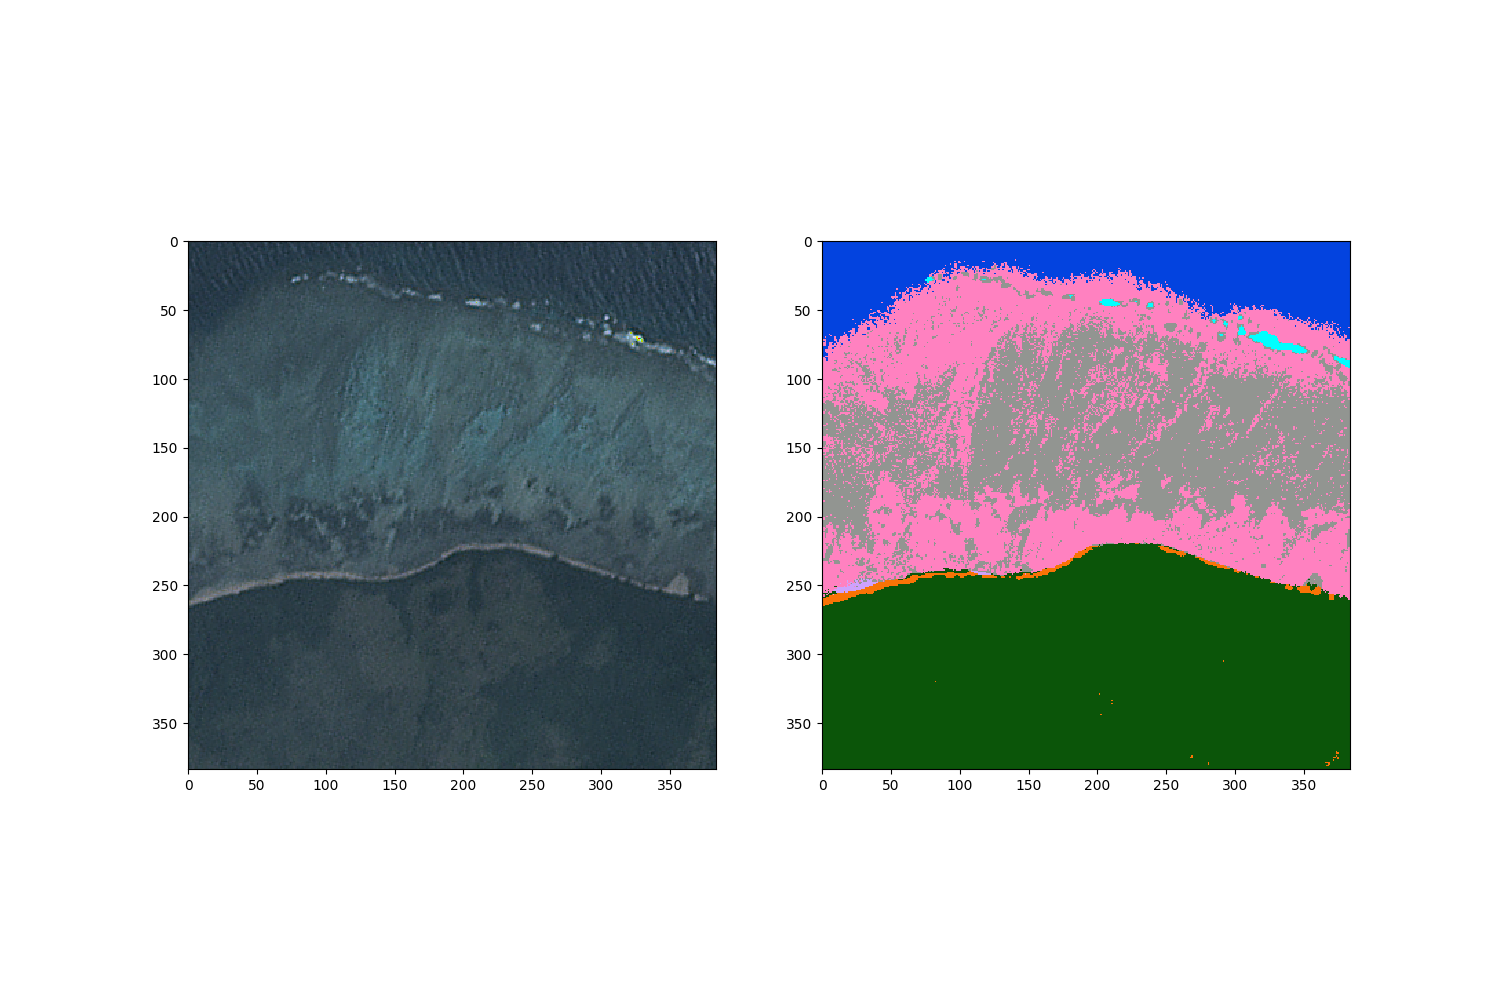

In [260]:
coralidx = 0
sedimentidx = 1
seagrassidx = 3
oceanidx = 5
svm_predict = np.copy(final_predict)
svm_predict_prob = np.copy(prob_predict)

totalcorals = img.testimage[offstart+corals[0][:], offstart+corals[1][:], :]
totalcorals_predict = clf_all.predict(totalcorals)
totalcorals_predictprob = clf_all.predict_proba(totalcorals)

totalsediment = img.testimage[offstart+sediment[0][:],offstart+sediment[1][:], :]
totalsediment_predict = clf_all.predict(totalsediment)
totalsediment_predictprob = clf_all.predict_proba(totalsediment)

if len(seagrass_highprob[0]) >= n_sg_cutoff:
    totalseagrass = img.testimage[offstart+seagrass[0][:], offstart+seagrass[1][:], :]
    totalseagrass_predict = clf_all.predict(totalseagrass)
    totalseagrass_predictprob = clf_all.predict_proba(totalseagrass)

if len(clouds_highprob[0]) >= 100:
    totalclouds = img.testimage[offstart+clouds[0][:], offstart+clouds[1][:],:]
#     totalclouds_predict = clf_clouds.predict(totalclouds)
#     totalclouds_predictprob = clf_clouds.predict_proba(totalclouds)
    for i in range(len(clouds[0])):
        if clustering_all.labels_[i] in cloud_repredict_list:
            repredict_clouds = clf_all.predict(np.expand_dims(totalclouds[i], axis=0))
            repredictprob_clouds = clf_all.predict_proba(np.expand_dims(totalclouds[i], axis=0))
            if repredict_clouds[0] == combineidx["Coral"]:
                svm_predict[clouds[0][i],clouds[1][i]] = coralidx
            elif repredict_clouds[0] == combineidx["Sediment"]:
                svm_predict[clouds[0][i],clouds[1][i]] = sedimentidx
            if len(seagrass_highprob[0]) >= 100:
                if repredict_clouds[0] == combineidx["Seagrass"]:
                    svm_predict[clouds[0][i],clouds[1][i]] = seagrassidx
                svm_predict_prob[clouds[0][i],clouds[1][i],seagrassidx] = repredictprob_clouds[0][combineidx["Seagrass"]]
            svm_predict_prob[clouds[0][i],clouds[1][i],:] = 0
            svm_predict_prob[clouds[0][i],clouds[1][i],coralidx] = repredictprob_clouds[0][combineidx["Coral"]]
            svm_predict_prob[clouds[0][i],clouds[1][i],sedimentidx] = repredictprob_clouds[0][combineidx["Sediment"]]
#             svm_predict_prob[clouds[0][i],clouds[1][i],oceanidx] = repredictprob_clouds[0][combineidx["Ocean"]]

for i in range(len(corals[0])):
    svm_predict_prob[corals[0][i],corals[1][i],:] = 0
    if totalcorals_predict[i] == combineidx["Coral"]:
        svm_predict[corals[0][i],corals[1][i]] = coralidx
    elif totalcorals_predict[i] == combineidx["Sediment"]:
        svm_predict[corals[0][i],corals[1][i]] = sedimentidx
#     elif totalcorals_predict[i] == combineidx["Ocean"]:
#         svm_predict[corals[0][i],corals[1][i]] = oceanidx
    if len(seagrass_highprob[0]) >= n_sg_cutoff:
        if totalcorals_predict[i] == combineidx["Seagrass"]:
            svm_predict[corals[0][i],corals[1][i]] = seagrassidx
        svm_predict_prob[corals[0][i],corals[1][i],seagrassidx] = totalcorals_predictprob[i][combineidx["Seagrass"]]

    svm_predict_prob[corals[0][i],corals[1][i],coralidx] = totalcorals_predictprob[i][combineidx["Coral"]]
    svm_predict_prob[corals[0][i],corals[1][i],sedimentidx] = totalcorals_predictprob[i][combineidx["Sediment"]]
#     svm_predict_prob[corals[0][i],corals[1][i],oceanidx] = totalcorals_predictprob[i][combineidx["Ocean"]]

        
for i in range(len(sediment[0])):
    svm_predict_prob[sediment[0][i],sediment[1][i],:] = 0
    if totalsediment_predict[i] == combineidx["Coral"]:
        svm_predict[sediment[0][i],sediment[1][i]] = coralidx
    elif totalsediment_predict[i] == combineidx["Sediment"]:
        svm_predict[sediment[0][i],sediment[1][i]] = sedimentidx
    if len(seagrass_highprob[0]) >= n_sg_cutoff:
        if totalsediment_predict[i] == combineidx["Seagrass"]:
            svm_predict[sediment[0][i],sediment[1][i]] = seagrassidx
        svm_predict_prob[sediment[0][i],sediment[1][i],seagrassidx] = totalsediment_predictprob[i][combineidx["Seagrass"]]
        
    svm_predict_prob[sediment[0][i],sediment[1][i],coralidx] = totalsediment_predictprob[i][combineidx["Coral"]]
    svm_predict_prob[sediment[0][i],sediment[1][i],sedimentidx] = totalsediment_predictprob[i][combineidx["Sediment"]]
#     svm_predict_prob[sediment[0][i],sediment[1][i],oceanidx] = totalsediment_predictprob[i][combineidx["Ocean"]]

if len(seagrass_highprob[0]) >= n_sg_cutoff:
    for i in range(len(seagrass[0])):
        if totalseagrass_predict[i] == combineidx["Coral"]:
            svm_predict[seagrass[0][i],seagrass[1][i]] = coralidx
        elif totalseagrass_predict[i] == combineidx["Sediment"]:
            svm_predict[seagrass[0][i],seagrass[1][i]] = sedimentidx
        elif totalseagrass_predict[i] == combineidx["Seagrass"]:
            svm_predict[seagrass[0][i],seagrass[1][i]] = seagrassidx
        svm_predict_prob[seagrass[0][i],seagrass[1][i],:] = 0
        svm_predict_prob[seagrass[0][i],seagrass[1][i],coralidx] = totalseagrass_predictprob[i][combineidx["Coral"]]
        svm_predict_prob[seagrass[0][i],seagrass[1][i],sedimentidx] = totalseagrass_predictprob[i][combineidx["Sediment"]]
        svm_predict_prob[seagrass[0][i],seagrass[1][i],seagrassidx] = totalseagrass_predictprob[i][combineidx["Seagrass"]]
#         svm_predict_prob[seagrass[0][i],seagrass[1][i],oceanidx] = totalseagrass_predictprob[i][combineidx["Ocean"]]
    
                
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(pic[offstart:ylen-offstart,offstart:xlen-offstart,:])
# ax.scatter(y=corals_highprob[0], x=corals_highprob[1], c='m', s=1)
# ax.scatter(y=sediment_highprob[0], x=sediment_highprob[1], c='c', s=1)
# ax.scatter(y=seagrass_highprob[0], x=seagrass_highprob[1], c='g', s=1)

ax = plt.subplot(122)
ax.imshow(svm_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.show()

KL-divergence at 0: -1185559.5175122332
KL-divergence at 1: -1385311.3154506802
KL-divergence at 2: -1399087.6272069553
KL-divergence at 3: -1401839.1527847082
KL-divergence at 4: -1402677.7039368968
KL-divergence at 5: -1403017.0628257133
KL-divergence at 6: -1403175.947749896
KL-divergence at 7: -1403269.3013586493
KL-divergence at 8: -1403335.806072412
KL-divergence at 9: -1403388.9780964185
KL-divergence at 10: -1403424.4279407812
KL-divergence at 11: -1403449.0272496082
KL-divergence at 12: -1403463.3657021767
KL-divergence at 13: -1403472.7376309112
KL-divergence at 14: -1403480.6703434396
KL-divergence at 15: -1403486.703258749
KL-divergence at 16: -1403491.845294123
KL-divergence at 17: -1403496.7989077582
KL-divergence at 18: -1403500.6561784614
KL-divergence at 19: -1403503.8901704287


<IPython.core.display.Javascript object>


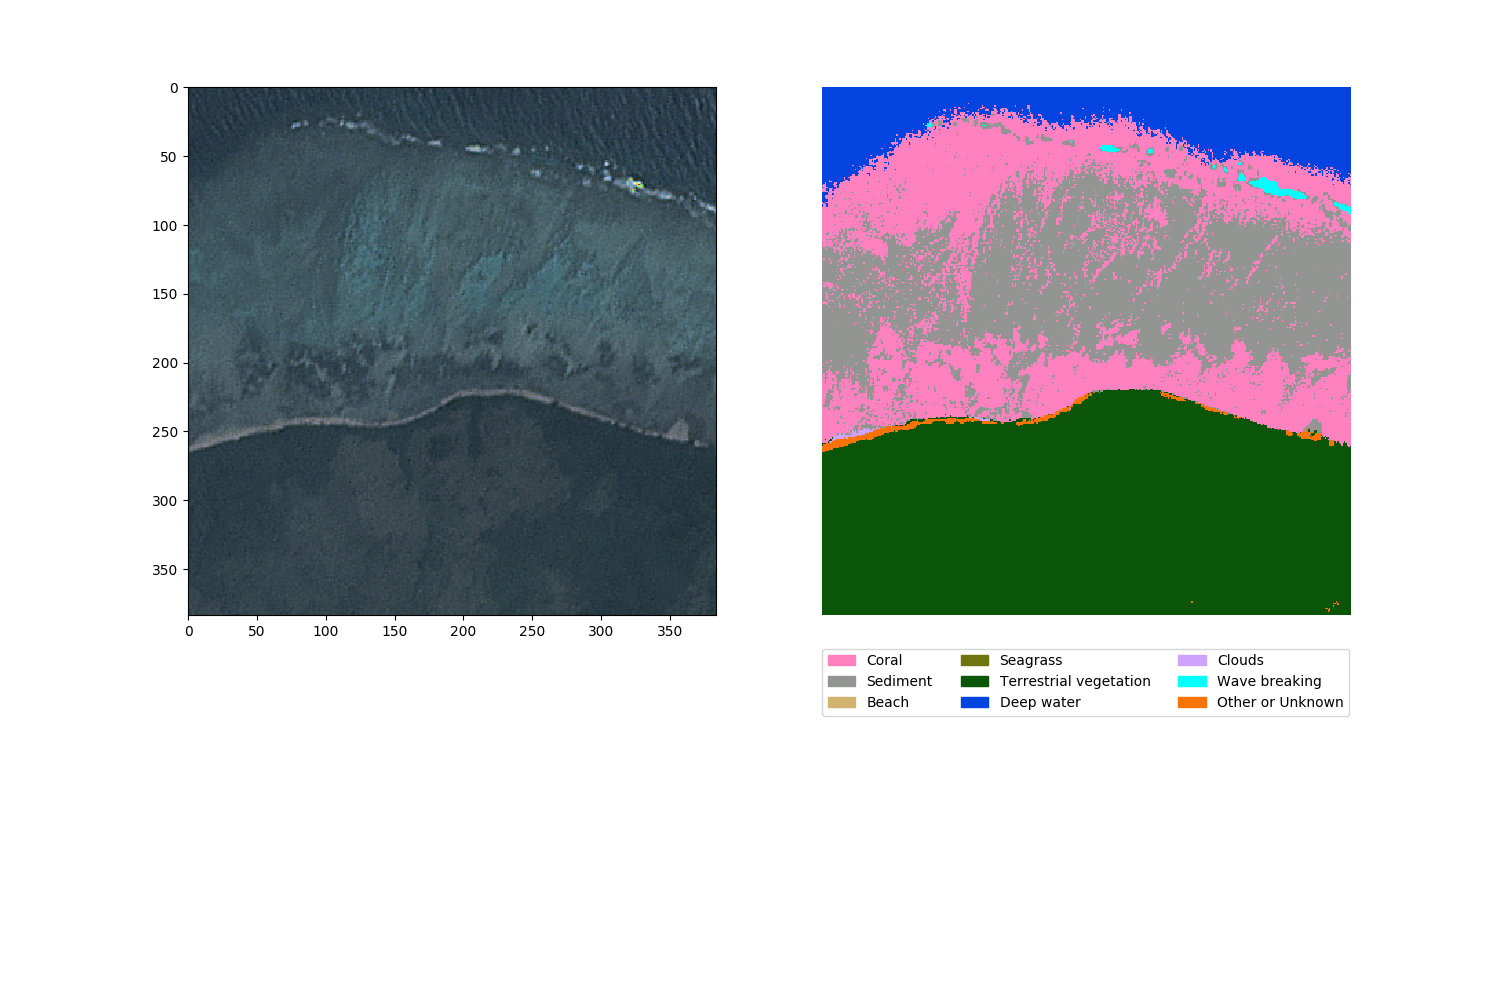

In [261]:
prob_predict_switch_trans = np.rollaxis(svm_predict_prob,2,0)
U = unary_from_softmax(prob_predict_switch_trans)
d = dcrf.DenseCRF2D(xlen-2*offstart, ylen-2*offstart,len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(3,3), shape=whole_predict.shape[:2]) # smaller the sdims, the more important it is
d.addPairwiseEnergy(pairwise_gaussian, compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
pairwise_bilateral = create_pairwise_bilateral(sdims=(25,25), schan=3, img=img.testimage[offstart:ylen-offstart,offstart:xlen-offstart], chdim=2) 
d.addPairwiseEnergy(pairwise_bilateral, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

MAP = np.argmax(Q, axis=0)
final_predict_svm = np.reshape(MAP, (ylen-2*offstart, xlen-2*offstart))

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(pic[offstart:ylen-offstart,offstart:xlen-offstart,:])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])

ax = plt.subplot(122)
ax.imshow(final_predict_svm.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
ax.set_axis_off()
plt.show()

In [262]:
# save grayscale nemo predict file for truth compare
# filename = 'Coral_00000014.png'
filename = 'Coral_' + str(imgnum).zfill(8) + '.png'
graypath = '../Images/Alan_TestSet/SharpMask_Final/' + filename
lofgraypath = '../Images/Alan_TestSet/LOFmap_Gray/' + filename
classify_offset = 64

classvalues = [labelkey[k] for k in labelkey]
classlen = len(classvalues)
predict_patch = final_predict_svm+1
Graypatch = predict_patch[classify_offset:classify_offset+256,classify_offset:classify_offset+256]
Graypatch = np.asarray(np.floor(255.0/classlen*Graypatch), dtype=np.uint8)
cv2.imwrite(graypath, Graypatch)

# LOFGraypatch = Testtruth[classify_offset:classify_offset+256,classify_offset:classify_offset+256]
# LOFGraypatch = np.asarray(np.floor(255.0/classlen*LOFGraypatch), dtype=np.uint8)
# cv2.imwrite(lofgraypath, LOFGraypatch)

True

<IPython.core.display.Javascript object>


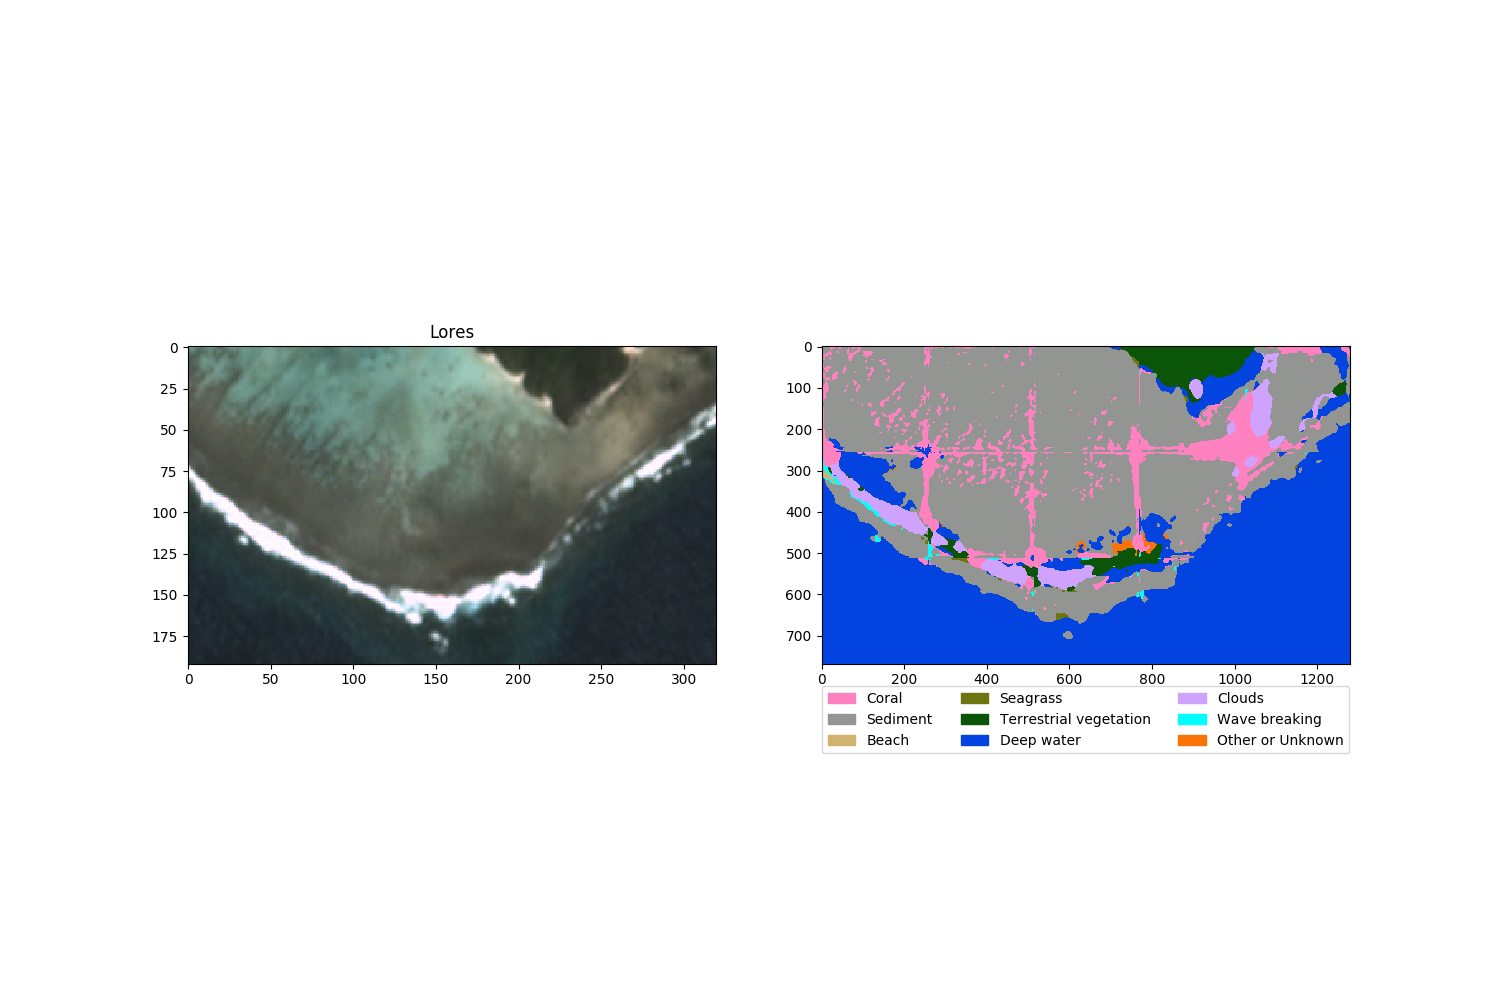

Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed
Line: 0 Col: 0/ 1 completed


In [42]:
from keras.preprocessing.image import img_to_array
import keras.backend as K

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

ymin = 1500
xmin = 1400
rows = 3
cols = 5
l = 64
samplepatch_RGB = img.image[ymin:ymin+l*rows,xmin:xmin+l*cols,2::-1]
samplepatch_RGB = np.asarray(np.clip(255/3000*samplepatch_RGB,0,255), dtype=np.uint8)

fig = plt.figure(4, figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(samplepatch_RGB)
ax.set_title('Lores')

# Turn patch into standardized BGR + NIR
pixel_mean =1500
pixel_std = 1500
# samplepatch = np.dstack((img.image[ymin:ymin+l,xmin:xmin+l,0:3],img.image[ymin:ymin+l,xmin:xmin+l,-1])) #BGR+NIR


jsonclasspath = './utils/CoralClasses.json'

with open(jsonclasspath) as json_file:
    json_classes = json.load(json_file)

labelkey = json_classes["VedConsolidated_ClassDict"]
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v

whole_imgpredict_fix = np.zeros((rows*l*4,cols*l*4,4), dtype=np.uint8)
whole_imgpredict = np.zeros((rows*l*4,cols*l*4), dtype=np.uint8)

for j in range(rows):
    for i in range(cols):
        samplepatch = img.image[ymin+j*l:ymin+(j+1)*l,xmin+i*l:xmin+(i+1)*l,:]
        samplepatch = img_to_array(samplepatch, data_format=K.image_data_format())
        samplepatch = (samplepatch-pixel_mean)/pixel_std

        imgbatch = np.expand_dims(samplepatch, axis=0)
        imgpredict = supermodel.predict(imgbatch, batch_size = 1)[0]
        kernel_sharpening = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        imgpredict_sharpen = np.zeros(imgpredict.shape)
        for k in range(4):
            imgpredict_sharpen[:,:,k] = cv2.filter2D(imgpredict[:,:,k], -1, kernel_sharpening)
#         imgpredict_sharpen = np.dstack((imgpredict_sharpen[:,:,2::-1],imgpredict_sharpen[:,:,-1])) #RGB+NIR
        imgpredict_sharpen = fixRGBimg(imgpredict_sharpen,100,100,0,255)
        
        predict_size = 256
        img.testimage = imgpredict_sharpen
        
        img.set_mean_std(140,105)
        whole_predict, num_predict, prob_predict, truth_predict, accuracy = img.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (256,256), predict_size = 256, num_lines=None, lastchannelremove=False)
        whole_imgpredict[j*l*4:(j+1)*l*4, i*l*4:(i+1)*l*4] = whole_predict
#         imgpredict = fixRGBimg(imgpredict_sharpen,100,100,0,255)
#         imgpredict_fix = np.zeros((imgpredict.shape[0],imgpredict.shape[1],4))
#         imgpredict_fix[:,:,0] = imgpredict[:,:,2]
#         imgpredict_fix[:,:,1] = imgpredict[:,:,1]
#         imgpredict_fix[:,:,2] = imgpredict[:,:,0]
#         imgpredict_fix[:,:,3] = imgpredict[:,:,3]
#         imgpredict_fix = np.asarray(imgpredict_fix, dtype=np.uint8)
#         whole_imgpredict_fix[j*l*4:(j+1)*l*4, i*l*4:(i+1)*l*4,:] = imgpredict_fix

ax = plt.subplot(1,2,2)
plt.imshow(whole_imgpredict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
plt.show()

# ax = plt.subplot(1,2,2)
# ax.imshow(whole_imgpredict_fix[:,:,:3])
# ax.set_title('SRx4')

<IPython.core.display.Javascript object>


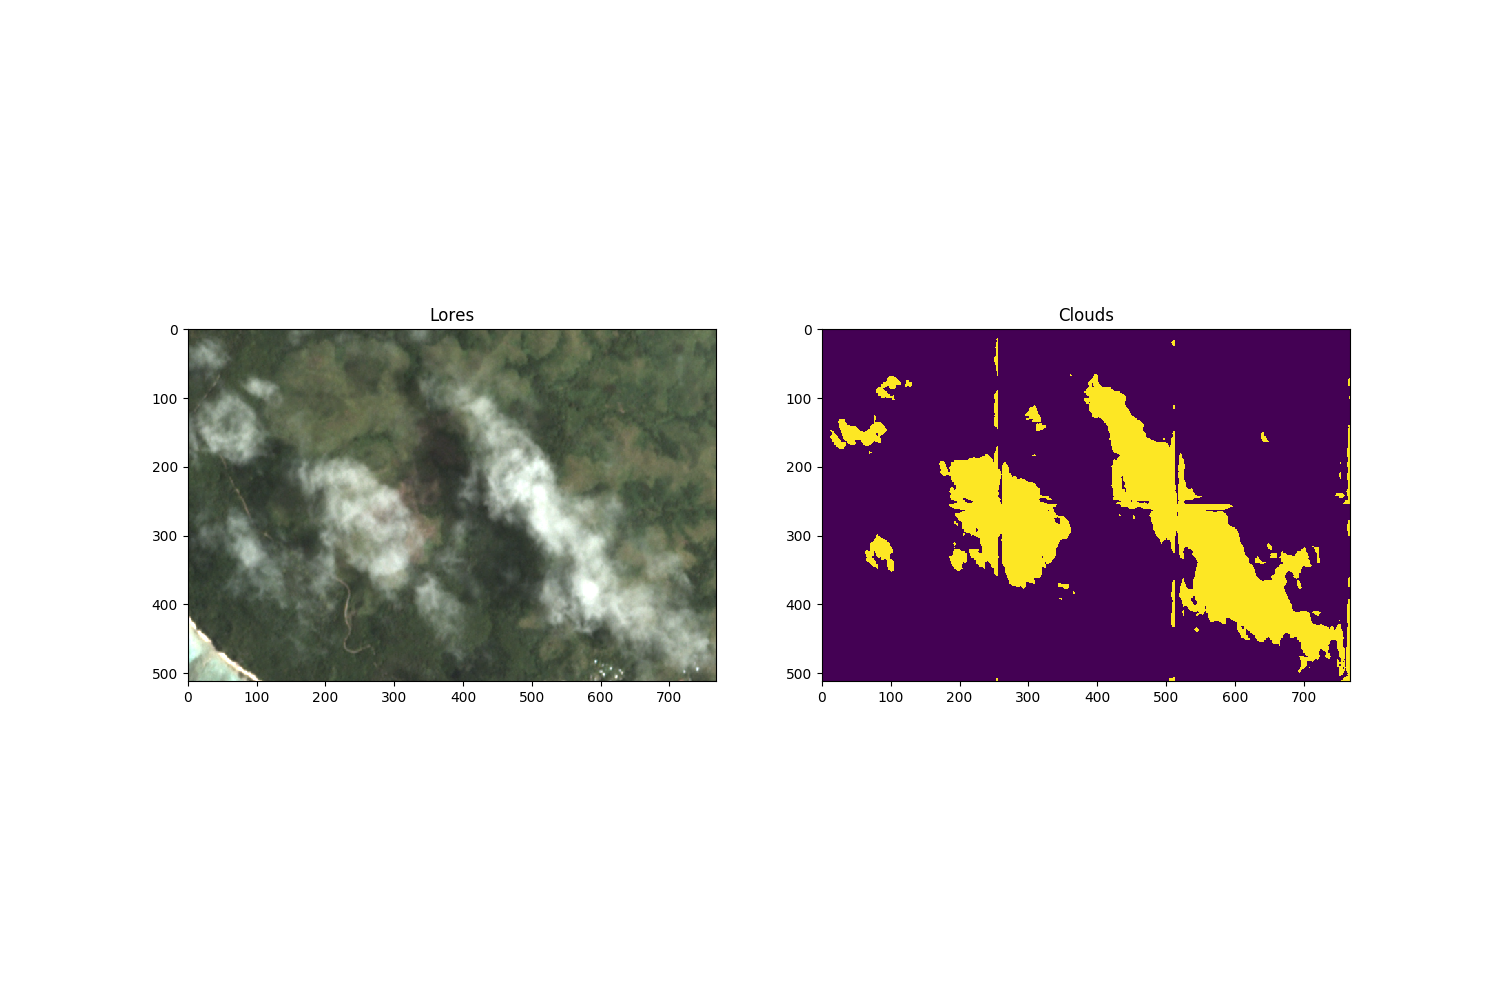

Text(0.5,1,'Clouds')

In [28]:
from keras.preprocessing.image import img_to_array
import keras.backend as K

ymin = 800
xmin = 1200
rows = 2
cols = 3
l = 256
samplepatch_RGB = img.image[ymin:ymin+l*rows,xmin:xmin+l*cols,2::-1]
samplepatch_RGB = np.asarray(np.clip(255/2000*samplepatch_RGB,0,255), dtype=np.uint8)

fig = plt.figure(5, figsize=(15,10))
ax = plt.subplot(1,2,1)
ax.imshow(samplepatch_RGB)
ax.set_title('Lores')

# Turn patch into standardized BGR + NIR
pixel_mean = 500
pixel_std = 1000
# samplepatch = np.dstack((img.image[ymin:ymin+l,xmin:xmin+l,0:3],img.image[ymin:ymin+l,xmin:xmin+l,-1])) #BGR+NIR

whole_imgpredict_fix = np.zeros((rows*l,cols*l), dtype=np.uint8)

for j in range(rows):
    for i in range(cols):
        samplepatch = img.image[ymin+j*l:ymin+(j+1)*l,xmin+i*l:xmin+(i+1)*l,:]
#         samplepatch = np.dstack((img.image[ymin+j*l:ymin+(j+1)*l,xmin+i*l:xmin+(i+1)*l,2::-1],img.image[ymin+j*l:ymin+(j+1)*l,xmin+i*l:xmin+(i+1)*l,-1])) #BGR+NIR
        samplepatch = img_to_array(samplepatch, data_format=K.image_data_format())
        samplepatch = (samplepatch-pixel_mean)/pixel_std

        imgbatch = np.expand_dims(samplepatch, axis=0)
        imgpredict = Cloudmodel.predict(imgbatch, batch_size = 1)[0]
        imgpredict = np.argmax(imgpredict,-1)
        imgpredict_fix = imgpredict.reshape((l,l))

        # imgpredict_sharpen = np.dstack((imgpredict_sharpen[:,:,2::-1],imgpredict_sharpen[:,:,-1])) #RGB+NIR
        imgpredict_fix = np.asarray(imgpredict_fix, dtype=np.uint8)
        
        whole_imgpredict_fix[j*l:(j+1)*l, i*l:(i+1)*l] = imgpredict_fix

ax = plt.subplot(1,2,2)
ax.imshow(whole_imgpredict_fix[:,:])
ax.set_title('Clouds')